In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import cv2


In [2]:
# Define dataset path
dataset_path = r"C:\Users\harsh\OneDrive\Desktop\Rice_Type_Detection\Data"

# Image size for MobileNet
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

# Data Augmentation and Image Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Check class labels
print("Class Indices:", train_generator.class_indices)


Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Class Indices: {'arborio': 0, 'basmati': 1, 'ipsala': 2, 'jasmine': 3, 'karacadag': 4}


In [10]:
# Load MobileNetV2 as base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')


# Freeze base model layers
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Model Summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128          │ (None, 4, 4, 1280)    │    2,257,984 │
│ (Functional)                  │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_1 (Flatten)           │ (None, 20480)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_3 (Dense)               │ (None, 128)           │    2,621,568 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_1 (Dropout)           │ (None, 128)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_4 (Dense)               │ (None, 64)            │        8,256 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_5 (Dense)               │ (None, 5)             │          325 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 4,888,133 (18.65 MB)

 Trainable params: 2,630,149 (10.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
EPOCHS = 5

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1763s 467ms/step - accuracy: 0.8854 - loss: 0.3661 - val_accuracy: 0.9606 - val_loss: 0.1145
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1218s 325ms/step - accuracy: 0.9493 - loss: 0.1657 - val_accuracy: 0.9657 - val_loss: 0.0994
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 1582s 422ms/step - accuracy: 0.9595 - loss: 0.1289 - val_accuracy: 0.9782 - val_loss: 0.0713
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 3049s 813ms/step - accuracy: 0.9625 - loss: 0.1127 - val_accuracy: 0.9699 - val_loss: 0.1050
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 2491s 664ms/step - accuracy: 0.9653 - loss: 0.1028 - val_accuracy: 0.9769 - val_loss: 0.0782


In [12]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Save the trained model
model.save("rice.h5")
print("Model saved as rice.h5")


938/938 ━━━━━━━━━━━━━━━━━━━━ 502s 535ms/step - accuracy: 0.9769 - loss: 0.0801
Validation Accuracy: 97.73%


Model saved as rice.h5


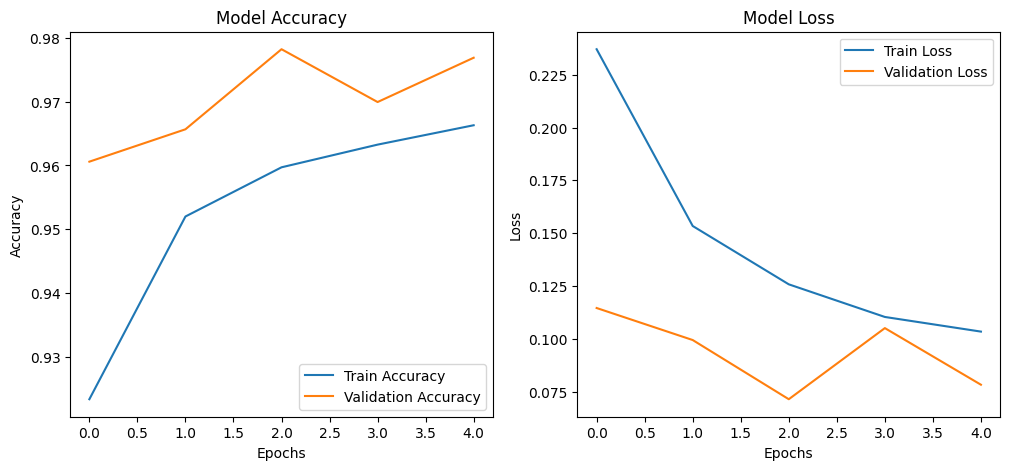

In [13]:
# Plot accuracy and loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [22]:
import cv2
import numpy as np
from keras.models import load_model

# Load Model
model = load_model("rice.h5")

# Define correct image size (based on the model input)
IMG_SIZE = (128, 128)  # Updated to match model requirement

# Load and preprocess image
def predict_rice(image_path):
    img = cv2.imread(image_path)
    
    if img is None:
        print("Error: Could not load image at", image_path)
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color
    img = cv2.resize(img, IMG_SIZE)  # Resize to match model input
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    
    # Prediction
    prediction = model.predict(img)
    class_index = np.argmax(prediction)
    
    # Define class labels (ensure they match your dataset)
    class_labels = ["arborio", "basmati", "jasmine", "karacadag"]  # Update this list
    predicted_class = class_labels[class_index]
    
    print(f"Predicted Rice Type: {predicted_class}")

# Example test
test_image_path = r"C:\Users\harsh\OneDrive\Desktop\Rice_Type_Detection\Data\arborio\Arborio (1).jpg"
predict_rice(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Rice Type: arborio
